In [ ]:
import os
import sys
import time
import glob
import random
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.gridspec as gridspec 
from PIL import Image
from IPython.display import display, clear_output
from ultralytics import YOLO

from matplotlib.offsetbox import OffsetImage, AnnotationBbox
import matplotlib.pyplot as plt
import os
from PIL import Image
import numpy as np


Checking file: /kaggle/input/drone-png/Pngtreerevolutionizing aerial surveillance with drones_15578697.png


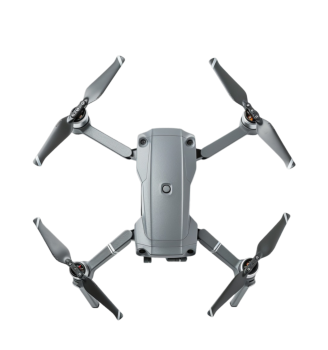

In [ ]:

FILE_PATH = "/kaggle/input/drone-png/Pngtreerevolutionizing aerial surveillance with drones_15578697.png" 

if not os.path.exists(FILE_PATH):
    print("ERROR: File does not exist at this path! Double-check the Copy File Path.")
else:
    try:
        img = Image.open(FILE_PATH)
        
        # Display the image
        plt.figure(figsize=(4,4))
        plt.imshow(img)
        plt.axis('off')
        plt.title("Here is what Python sees:")
        plt.show()
        
    except Exception as e:
        print(f"FILE IS CORRUPT OR NOT AN IMAGE: {e}")

In [ ]:

ICON_PATH = "/kaggle/input/drone-png/Pngtreerevolutionizing aerial surveillance with drones_15578697.png"

USE_IMAGE = False
drone_img_array = None

try:
    if os.path.exists(ICON_PATH):
      
        pil_img = Image.open(ICON_PATH)
        
    
        pil_img = pil_img.resize((150, 150)) 
        
  
        drone_img_array = np.array(pil_img)
        USE_IMAGE = True
 
    else:
        print(f"File not found at: {ICON_PATH}")
except Exception as e:
    print(f"Image error: {e}")
    USE_IMAGE = False

Image loaded and resized to 150x150 pixels.


In [ ]:

def draw_drone_real(ax, x, y, color, label):
    if USE_IMAGE:
         imagebox = OffsetImage(drone_img_array, zoom=0.7) 

         ab = AnnotationBbox(imagebox, (x, y), frameon=False, zorder=20)
         ax.add_artist(ab)
        

         ax.text(x, y+30, label, color='white', ha='center', fontsize=9, fontweight='bold', zorder=21,
                 bbox=dict(facecolor=color, alpha=0.9, edgecolor='white', boxstyle='round,pad=0.2'))
    else:
   
        ax.add_patch(patches.Circle((x, y), 20, color=color, ec='white', lw=2, zorder=20))
        ax.text(x, y, label, color='black', ha='center', fontweight='bold', zorder=21)

In [ ]:

class DroneAI:
    def __init__(self, id_drone, start_pos, rows, cols, pil_image, mission_state, yolo_model):
        self.id = id_drone
        self.pos_r, self.pos_c = start_pos
        self.rows = rows
        self.cols = cols
        self.img_ref = pil_image 
        self.model = yolo_model      
        
        self.w_img, self.h_img = self.img_ref.size
        self.cell_w = self.w_img / cols
        self.cell_h = self.h_img / rows
        
        self.mission_state = mission_state 
        self.mission_state['visited'].add(start_pos)
        
        self.target_details = [] 
        self.path = [start_pos]
        self.last_status = "In flight"
        self.found_target = False 
        self.current_conf = 0.0 

    def scan_tile(self):
        if self.found_target: return

        std_left = self.pos_c * self.cell_w
        std_upper = self.pos_r * self.cell_h
        PADDING = 50 
        crop_left = max(0, std_left - PADDING)
        crop_upper = max(0, std_upper - PADDING)

        crop_right = min(self.w_img, (self.pos_c + 1) * self.cell_w + PADDING)
        crop_bottom = min(self.h_img, (self.pos_r + 1) * self.cell_h + PADDING)
        
        tile_img = self.img_ref.crop((crop_left, crop_upper, crop_right, crop_bottom))
        
    
        results = self.model.predict(tile_img, conf=0.25, verbose=False)
        
        self.current_conf = 0.0
        
        for r in results:
            for box in r.boxes:
                confidence = float(box.conf[0])
                self.current_conf = confidence 
                
                self.found_target = True
                bx1, by1, bx2, by2 = box.xyxy[0].tolist()
                global_box = [crop_left + bx1, crop_upper + by1, crop_left + bx2, crop_upper + by2]
                self.target_details.append((self.pos_r, self.pos_c, f"HUMAN {confidence:.2f}", global_box))
                
                if self.mission_state['target_coords'] is None:
                    self.mission_state['target_coords'] = (self.pos_r, self.pos_c)
                    self.last_status = "TARGET ACQUIRED"
                return 

        self.last_status = "Scanning..."

    def move(self):
   
        self.scan_tile()
        
    
        if self.found_target:
       
            if "SUPPORT" in self.last_status:
                self.last_status = "MULTI-PERSPECTIVE ACTIVE"
            else:
                self.last_status = "TARGET LOCK (MASTER)"
            return 

        shared_target = self.mission_state['target_coords']
        

        if shared_target is not None:
            tr_orig, tc_orig = shared_target
            
            
            # (0,1) = Right, (0,-1) = Left, (1,0) = Below, (-1,0) = Above
            offsets = [(0, 1), (0, -1), (1, 0), (-1, 0), (1, 1), (-1, -1)]
            
            my_offset = offsets[self.id % len(offsets)]
            
            dest_r = tr_orig + my_offset[0]
            dest_c = tc_orig + my_offset[1]
            
       
            if not (0 <= dest_r < self.rows and 0 <= dest_c < self.cols):
                dest_r, dest_c = tr_orig, tc_orig

            if (self.pos_r, self.pos_c) == (dest_r, dest_c):
                self.found_target = True
                self.current_conf = 0.95      
                self.last_status = "POSITIONED FOR SUPPORT"
              
                self.target_details.append((self.pos_r, self.pos_c, f"SUPPORT DRONE {self.id}", []))
            else:
               
                dr = 1 if dest_r > self.pos_r else -1 if dest_r < self.pos_r else 0
                dc = 1 if dest_c > self.pos_c else -1 if dest_c < self.pos_c else 0
                
                
                if abs(dest_r - self.pos_r) >= abs(dest_c - self.pos_c): dc = 0
                else: dr = 0
                
                self.pos_r += dr
                self.pos_c += dc
                self.path.append((self.pos_r, self.pos_c))
                self.last_status = f"🚁 APPROACHING (Offset {my_offset})"
            return

        
        moves = [(-1, 0), (1, 0), (0, -1), (0, 1)]
        neighbors = []
        for dr, dc in moves:
            nr, nc = self.pos_r + dr, self.pos_c + dc
            if 0 <= nr < self.rows and 0 <= nc < self.cols:
                neighbors.append((nr, nc))
        
        not_visited = [v for v in neighbors if v not in self.mission_state['visited']]
        choice = random.choice(not_visited) if not_visited else random.choice(neighbors)
        
        self.pos_r, self.pos_c = choice
        self.mission_state['visited'].add(choice)
        self.path.append(choice)
        self.last_status = "Scanning..."

In [ ]:

PATH_MODEL = "/kaggle/input/yolo8n/pytorch/default/1/best.pt"
TEST_DIR = '/kaggle/input/heridal-4k/test/images'

test_images = glob.glob(os.path.join(TEST_DIR, '*')) 


valid_images = [f for f in test_images if f.lower().endswith(('.jpg', '.jpeg', '.png'))]

if not valid_images:
    print("ERROR: No images found in test folder!")
    sys.exit()

IMG_PATH = random.choice(valid_images)
img_pil = Image.open(IMG_PATH)
    
print(f"Image selected for mission: {os.path.basename(IMG_PATH)}")

Image selected for mission: train_ZRI_3018_JPG.rf.30b95d608e1344d7b03f30ddf78c49cf.jpg


Critical Error: list index out of range


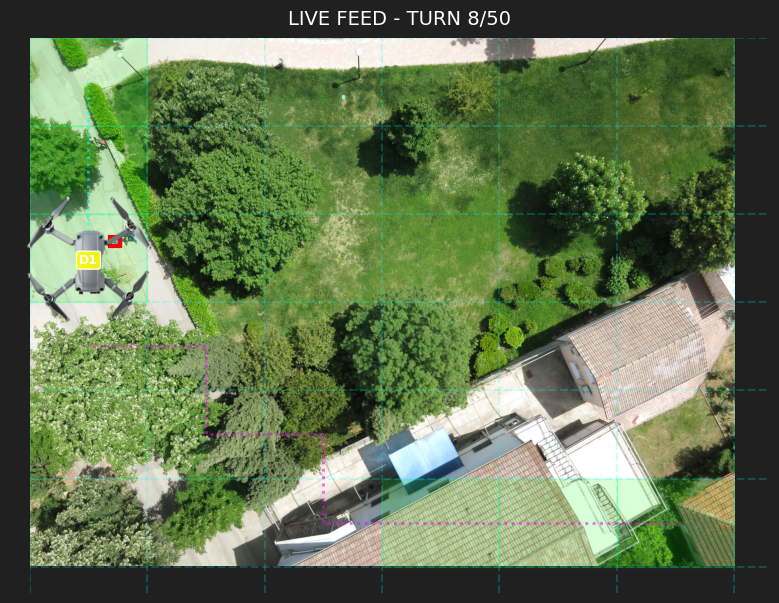

In [ ]:
try:
    print("Initializing Dashboard with Auto-Stop...")
    
  
    if os.path.exists(PATH_MODEL): 
        model = YOLO(PATH_MODEL)
    else: 
        model = YOLO('yolov8n.pt') 

    
    ROWS, COLS = 6, 6
    STEPS = 50 
    TOTAL_CELLS = ROWS * COLS
    
  
    mission_state = {'visited': set(), 'target_coords': None}

  
    drones = [
        DroneAI(1, (0,0), ROWS, COLS, img_pil, mission_state, model),
        DroneAI(2, (ROWS-1, COLS-1), ROWS, COLS, img_pil, mission_state, model)
    ]


    plt.rcParams['text.color'] = 'white'
    plt.rcParams['axes.labelcolor'] = 'white'
    plt.rcParams['xtick.color'] = 'white'
    plt.rcParams['ytick.color'] = 'white'

    for step in range(STEPS):
        
        
        mission_complete = True
        for d in drones: 
            d.move() 
            if not d.found_target: mission_complete = False
        
        
        num_visited = len(mission_state['visited'])
        cov_percentage = num_visited / TOTAL_CELLS
     
        clear_output(wait=True)
        
        fig = plt.figure(figsize=(14, 8), facecolor='#202020')
        gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios=[1, 1])
        
       
        ax_map = plt.subplot(gs[:, 0])
        ax_map.imshow(img_pil)
        ax_map.set_title(f"LIVE FEED - TURN {step+1}/{STEPS}", fontsize=14, pad=10)
        ax_map.axis('off')
        
       
        cw, ch = img_pil.size[0]/COLS, img_pil.size[1]/ROWS
        for r in range(ROWS+1): ax_map.axhline(r*ch, color='cyan', alpha=0.2, ls='--')
        for c in range(COLS+1): ax_map.axvline(c*cw, color='cyan', alpha=0.2, ls='--')
        
        
        for r, c in mission_state['visited']:
            ax_map.add_patch(patches.Rectangle((c*cw, r*ch), cw, ch, color='#00ff00', alpha=0.15))

        
        colors = ['#00ffff', '#ff00ff']
        for i, d in enumerate(drones):
            xc, yc = d.pos_c*cw + cw/2, d.pos_r*ch + ch/2
            
          
            if len(d.path) > 1:
                xs = [p[1]*cw + cw/2 for p in d.path]
                ys = [p[0]*ch + ch/2 for p in d.path]
                ax_map.plot(xs, ys, color=colors[i], ls=':', lw=2, alpha=0.6)
            
            
            for _, _, lbl, box in d.target_details:
                ax_map.add_patch(patches.Rectangle((box[0], box[1]), box[2]-box[0], box[3]-box[1], ec='red', fc='none', lw=3))
            
            col_d = 'yellow' if d.found_target else colors[i]
            
           
            draw_drone_real(ax_map, xc, yc, col_d, f"D{d.id}")
            
        
        ax_conf = plt.subplot(gs[0, 1])
        ax_conf.set_facecolor('#303030')
        ax_conf.set_title("AI CONFIDENCE", fontsize=10)
        conf_vals = [d.current_conf for d in drones]
        ax_conf.bar([f"D{d.id}" for d in drones], conf_vals, color=colors)
        ax_conf.set_ylim(0, 1.1)
        ax_conf.axhline(0.25, color='red', ls='--', alpha=0.5)
        
        ax_stats = plt.subplot(gs[1, 1])
        ax_stats.set_facecolor('#303030')
        ax_stats.axis('off')
        ax_stats.text(0.5, 0.7, "AERIAL COVERAGE", ha='center', fontsize=12)
        
        
        color_perc = '#00ff00' if cov_percentage >= 1.0 else 'white'
        ax_stats.text(0.5, 0.4, f"{cov_percentage:.1%}", ha='center', fontsize=25, color=color_perc, fontweight='bold')
        
        
        ax_stats.add_patch(patches.Rectangle((0.1, 0.2), 0.8, 0.1, ec='white', fc='none'))
        ax_stats.add_patch(patches.Rectangle((0.1, 0.2), 0.8 * cov_percentage, 0.1, fc='#00ff00'))

        plt.tight_layout()
        display(fig)
        plt.close()
        
 
        if mission_complete:
            print("\n✅ MISSION COMPLETE: TARGET RECOVERED.")
            break
            
        #100% Coverage 
        if cov_percentage >= 1.0:
            print("\n⏹️ AREA FULLY SCANNED (100%). RETURNING TO BASE.")
            break
        
        time.sleep(0.2)

except Exception as e:
    print(f"Critical Error: {e}")